In [1]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import string
from nltk.tokenize import TweetTokenizer
tokenizer=TweetTokenizer()
import re


In [2]:
train_data=pd.read_csv('/content/drive/MyDrive/Twitter sentiment/Tweets_train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/Twitter sentiment/New_Tweets_test-1.csv')
dev_data=pd.read_csv('/content/drive/MyDrive/Twitter sentiment/Tweets_dev.csv')


In [3]:

train_data.head()

train_data['airline_sentiment'].value_counts()
test_data['airline_sentiment'].value_counts()

print("train - ",train_data.shape)
print("test - ",test_data.shape)
print("dev - ",dev_data.shape)

train -  (11858, 3)
test -  (1464, 4)
dev -  (1318, 3)


In [4]:
train_data.head()

,tweet_id,text,airline_sentiment
0,569179849518161920,@united you're good. Thank you!,positive
1,569835751275433984,"@AmericanAir way to ruin a vacation, my brothe...",negative
2,568588936852799488,@JetBlue yes thankfully! Catering just got her...,positive
3,569525116725567491,@USAirways The automated message isn't helpful...,negative
4,568807823187976193,@JetBlue I'm #MakingLoveOutofNothingAtAll on m...,positive


In [5]:
test_data=test_data.drop(columns=['Unnamed: 0'])

In [9]:
train_data.shape

(11858, 3)

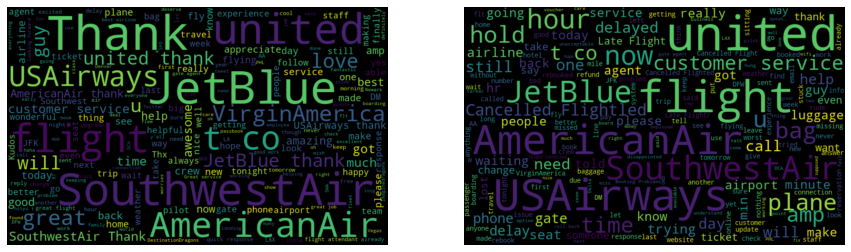

In [ ]:
from wordcloud import WordCloud
# frequent words visualization for +ve
all_words_positive = " ".join([sentence for sentence in train_data['text'][train_data['airline_sentiment']=='positive']])
all_words_negative = " ".join([sentence for sentence in train_data['text'][train_data['airline_sentiment']=='negative']])

wordcloud_p = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words_positive)
wordcloud_n = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words_negative)

# plot the graph
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(wordcloud_p, interpolation='bilinear')
ax[0].axis("off")
ax[1].imshow(wordcloud_n, interpolation='bilinear')
ax[1].axis("off")

plt.show()

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def lemmatize_data(text_array):

  lemmatizer = WordNetLemmatizer()
  tokenized_tweet = [tokenizer.tokenize(i) for i in text_array]
  tokenized_tweet = [[j for j in i if j[0]!='@' and j not in string.punctuation] for i in tokenized_tweet]

  return [' '.join([lemmatizer.lemmatize(w) for w in i]) for i in tokenized_tweet]

  

In [ ]:
train_data['cleaned_data']=lemmatize_data(train_data['text'])
dev_data['cleaned_data']=lemmatize_data(dev_data['text'])
test_data['cleaned_data']=lemmatize_data(test_data['text'])

In [ ]:
train_data.head()

,tweet_id,text,airline_sentiment,cleaned_data
0,569179849518161920,@united you're good. Thank you!,positive,you're good Thank you
1,569835751275433984,"@AmericanAir way to ruin a vacation, my brothe...",negative,way to ruin a vacation my brother ha called al...
2,568588936852799488,@JetBlue yes thankfully! Catering just got her...,positive,yes thankfully Catering just got here and now ...
3,569525116725567491,@USAirways The automated message isn't helpful...,negative,The automated message isn't helpful and it's i...
4,568807823187976193,@JetBlue I'm #MakingLoveOutofNothingAtAll on m...,positive,I'm #MakingLoveOutofNothingAtAll on my #brandl...


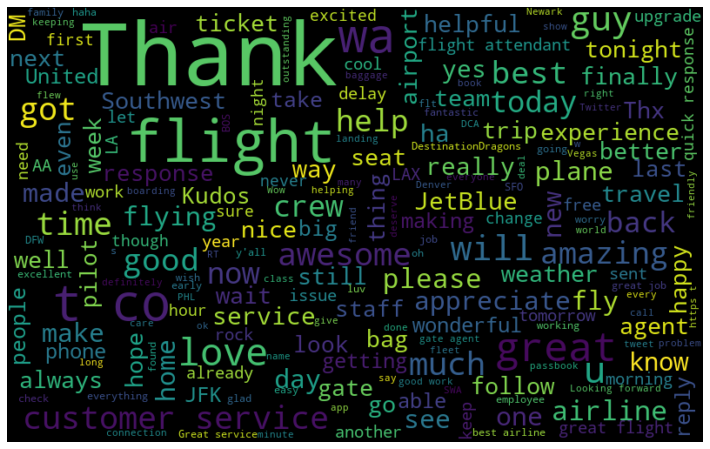

In [ ]:
from wordcloud import WordCloud
# frequent words visualization for +ve
all_words = " ".join([sentence for sentence in train_data['cleaned_data'][train_data['airline_sentiment']=='positive']])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

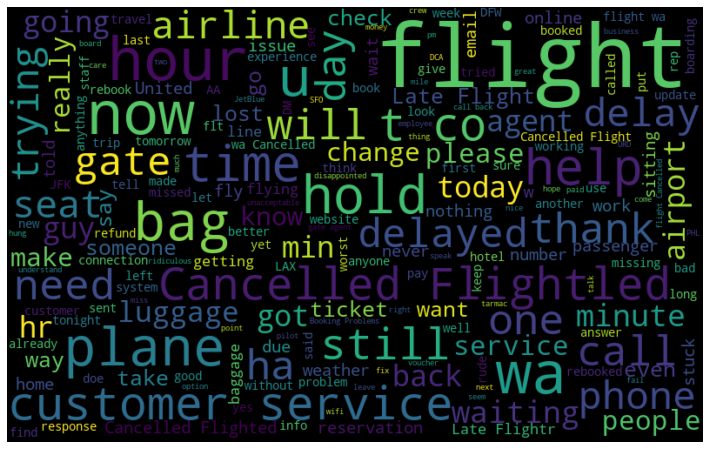

In [ ]:
# frequent words visualization for -ive
all_words = " ".join([sentence for sentence in train_data['cleaned_data'][train_data['airline_sentiment']=='negative']])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Data Augmentation

In [ ]:
pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 8.7 MB/s eta 0:00:00


In [ ]:
import nlpaug.augmenter.word as naw

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=2)
def data_augment(data):
  new_data=pd.DataFrame(columns=['tweet','airline_sentiment'])
  
  for i in data.iterrows():
    new_data=new_data.append(pd.DataFrame({'tweet':aug.augment(i[1]['cleaned_data'],n=2),
                                           'airline_sentiment':[i[1]['airline_sentiment']]*2
                                           }),ignore_index=True)  
  return new_data

In [ ]:
train_augmented=data_augment(train_data[['cleaned_data','airline_sentiment']])


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:

train_augmented['airline_sentiment'].value_counts()


negative    14868
neutral      5020
positive     3828
Name: airline_sentiment, dtype: int64

In [ ]:
# encoding target variable Y as 0,1,2 for neg.,neu., and pos. emotion respectively
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_augmented['airline_sentiment'])
dev_y= le.fit_transform(dev_data['airline_sentiment'])
test_y= le.fit_transform(test_data['airline_sentiment'])
train_y


array([2, 2, 0, ..., 0, 0, 0])

In [ ]:
# Setting X
train_x=train_augmented['tweet']
dev_x=dev_data['cleaned_data']
test_x=test_data['cleaned_data']

In [ ]:
train_x

0                               you ' re serious Thank you
1                                  you ' re full Thank you
2        way to ruin a vacation my brother ha call all ...
3        way to ruin a vacation my brother ha called al...
4        yes thankfully Catering simply got here and no...
                               ...                        
23711    grade for this trip Flight timeliness 👎 ✈ ️ Ca...
23712    Thanks for the vague canned response that does...
23713    Thanks for the vague canned response that does...
23714    already execute that at the airport and 12 hr ...
23715    already did that at the airport and 12 60 minu...
Name: tweet, Length: 23716, dtype: object

In [ ]:
# bag of words vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer() 
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x)
dev_x_vectors = vectorizer.transform(dev_x)



In [ ]:
train_x_vectors

<23716x15116 sparse matrix of type '<class 'numpy.float64'>'
	with 363568 stored elements in Compressed Sparse Row format>

## Applying different algorithms

SVM

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm

In [ ]:
def svm(train_x_vectors,train_y):

  clf_svm = svm.SVC(kernel='linear')

  clf_svm.fit(train_x_vectors, train_y)
  return clf_svm



In [ ]:
clf_svm=svm(train_x_vectors,train_y)

In [ ]:

dev_y_pred = clf_svm.predict(dev_x_vectors)
print("F1-score using dev data set:", f1_score(dev_y, dev_y_pred,average='micro'))

F1-score using dev data set: 0.7822458270106222


Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes(train_x_vectors,train_y)  :
  
  clf_mnb= MultinomialNB()
  clf_mnb.fit(train_x_vectors.toarray(),train_y)
  return clf_mnb

  

In [ ]:
naive_b=naive_bayes(train_x_vectors,train_y)
print("F1-score using dev dataset: ", f1_score(dev_y, naive_b.predict(dev_x_vectors),average='micro'))

F1-score using dev dataset:  0.6783004552352049


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
def log_reg(train_x_vectors, train_y):
  from sklearn.linear_model import LogisticRegression

  clf_log = LogisticRegression(max_iter=5000,solver='lbfgs',multi_class='multinomial')
  clf_log.fit(train_x_vectors, train_y)
  return clf_log

In [ ]:
clf_log=log_reg(train_x_vectors,train_y)
print("F1-score using dev dataset: ", f1_score(dev_y, clf_log.predict(dev_x_vectors),average='micro'))

F1-score using dev dataset:  0.7792109256449165


In [ ]:
clf_log.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def decision_tree(train_x_vectors, train_y):
    

    clf_dec = DecisionTreeClassifier()
    clf_dec.fit(train_x_vectors, train_y)
    return clf_dec

In [ ]:
clf_dec=decision_tree(train_x_vectors,train_y)
print("F1-score using dev dataset: ", f1_score(dev_y, clf_dec.predict(dev_x_vectors),average='micro'))

F1-score using dev dataset:  0.6881638846737481


LSTM Deep Classifier

In [ ]:
from keras_preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.layers import Embedding, LSTM, Dense, Dropout


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_words = 5000
max_len=220

def tokenize_pad_sequences(text):
    #tokenizing the input text and then padding each sequence to the same length
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X


In [ ]:
x_train_nn = tokenize_pad_sequences(train_augmented['tweet'])
x_test_nn = tokenize_pad_sequences(test_data['cleaned_data'])
x_val_nn = tokenize_pad_sequences(dev_data['cleaned_data'])

y_train_nn = pd.get_dummies(train_augmented['airline_sentiment'])
y_test_nn = pd.get_dummies(test_data['airline_sentiment'])
y_val_nn = pd.get_dummies(dev_data['airline_sentiment'])

In [ ]:
x_train_nn.shape,y_train_nn.shape

((23716, 220), (23716, 3))

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
#from keras.optimizers import SGD
#from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 10000
embedding_size = 32
epochs=20
#learning_rate = 0.1
#decay_rate = learning_rate / epochs
#momentum = 0.8

#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 220, 32)           320000    
                                                                 
 dropout_30 (Dropout)        (None, 220, 32)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 220, 32)           3104      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 110, 32)          0         
 g1D)                                                            
                                                                 
 lstm_21 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                     

In [ ]:
import tensorflow as tf
early_stopping= tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
batch_size = 64
history = model.fit(x_train_nn, y_train_nn,
                      validation_data=(x_val_nn, y_val_nn),
                      batch_size=batch_size, epochs=epochs, verbose=1,callbacks=early_stopping)

Epoch 1/20
371/371 [==============================] - 34s 84ms/step - loss: 0.9257 - accuracy: 0.6265 - precision_11: 0.6265 - recall_11: 0.6021 - val_loss: 0.9191 - val_accuracy: 0.6267 - val_precision_11: 0.6267 - val_recall_11: 0.6267
Epoch 2/20
371/371 [==============================] - 30s 80ms/step - loss: 0.9208 - accuracy: 0.6269 - precision_11: 0.6268 - recall_11: 0.6248 - val_loss: 0.9169 - val_accuracy: 0.6267 - val_precision_11: 0.6267 - val_recall_11: 0.6267
Epoch 3/20
371/371 [==============================] - 30s 80ms/step - loss: 0.9202 - accuracy: 0.6269 - precision_11: 0.6269 - recall_11: 0.6264 - val_loss: 0.9167 - val_accuracy: 0.6267 - val_precision_11: 0.6267 - val_recall_11: 0.6267
Epoch 4/20
371/371 [==============================] - 32s 85ms/step - loss: 0.9193 - accuracy: 0.6269 - precision_11: 0.6269 - recall_11: 0.6268 - val_loss: 0.9161 - val_accuracy: 0.6267 - val_precision_11: 0.6267 - val_recall_11: 0.6267
Epoch 5/20
371/371 [============================

In [ ]:
loss, accuracy, precision, recall = model.evaluate(x_test_nn, y_test_nn, verbose=0)
# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
F1 = 2 * (precision * recall) / (precision + recall)
print('F1 Score  : {:.4f}'.format(F1))
#F1 score: 0.6270

Accuracy  : 0.6270
Precision : 0.6270
Recall    : 0.6270
F1 Score  : 0.6270


Combining SVM, Naive Bayes, Logistic Regression and decision trees to give an an average of their prediction

In [ ]:
class Emsembled:
  def __init__(self,train_x_vectors,train_y):
    self.train_x_vectors=train_x_vectors
    self.train_y=train_y
    self.models=self.model_creation()

  def model_creation(self):
    SVM=svm(self.train_x_vectors,self.train_y)
    Naive_Bayes=naive_bayes(self.train_x_vectors,self.train_y)
    Log_Reg=log_reg(self.train_x_vectors,self.train_y)
    Dec_Tree=decision_tree(self.train_x_vectors, self.train_y)

    return [SVM,Naive_Bayes,Log_Reg,Dec_Tree]

  def internal_predict(self,test_x_vectors):
    pred_y=[]
    for i in self.models:
      pred_y.append(i.predict(test_x_vectors))
      
    positive_prob= list(pred_y).count(2)/4
    negative_prob= list(pred_y).count(0)/4
    neutral_prob= list(pred_y).count(1)/4
    max_prob=max(positive_prob,negative_prob,neutral_prob)
    if max_prob==positive_prob:
      return 2
    elif max_prob==negative_prob:
      return 0
    else:
      return 1
    
  def predict(self,test_x_vectors):
    result=[]
    if type(test_x_vectors[0]==list):
      for i in test_x_vectors:
        result.append(self.internal_predict(i))
      return result
    else:
      return self.internal_predict(test_x_vectors)



In [ ]:
obj=Emsembled(train_x_vectors,train_y)


In [ ]:
pred_emsembled=obj.predict(dev_x_vectors)
f1_score(dev_y, pred_emsembled,average='micro')

0.774658573596358

### Hyperparameter Model Tuning

In [ ]:
# Using validation set to tune the hyperparameters for SVM, takes 1hr 42 min
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
param_grid = {'C': [1,4,8,16], 'kernel': ['linear', 'rbf'], 'gamma':['scale','auto']}
random_search = RandomizedSearchCV(clf_svm, param_grid, cv=5)
random_search.fit(train_x_vectors, train_y)
best_parameters = random_search.best_params_
print(f'best parameters: {best_parameters}')

clf = svm.SVC(C=best_parameters['C'],gamma=best_parameters['gamma'], kernel=best_parameters['kernel'])
clf.fit(train_x_vectors, train_y)
print("F1-score using dev dataset: ", f1_score(dev_y,clf.predict(dev_x_vectors),average='micro'))

#.785280, 1hr 42 min,{'kernel': 'rbf', 'gamma': 'scale', 'C': 8}

best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 8}
F1-score using dev dataset:  0.7852807283763278


In [ ]:
# Evaluate the performance of the model on the test set


clf_svm = svm.SVC(C=8,gamma='scale', kernel='rbf')
clf_svm.fit(train_x_vectors, train_y)
y_test_pred = clf_svm.predict(test_x_vectors)
print("Accuracy on test dataset: ", accuracy_score(test_y, y_test_pred))
print("F1-score on test dataset: ", f1_score(test_y, y_test_pred,average='micro'))
print(clf_svm.score(test_x_vectors, test_y))
'''
Accuracy:  0.8066939890710383
F1-score:  0.8066939890710383
0.8066939890710383
'''


Accuracy on test dataset:  0.8066939890710383
F1-score on test dataset:  0.8066939890710383
0.8066939890710383


'\nAccuracy:  0.8066939890710383\nF1-score:  0.8066939890710383\n0.8066939890710383\n'

In [ ]:
import random
#hyperparameter tuning for Logistic regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

param_grid={'solver':['lbfgs','sag','newton-cg'],'C' : np.logspace(-4, 4, 20)}
r_search = RandomizedSearchCV(clf_log, param_grid, cv=5)
r_search.fit(train_x_vectors, train_y)
best_parameters = r_search.best_params_
print(f'best parameters: {best_parameters}')

clf_log = LogisticRegression(solver=best_parameters['solver'],C=best_parameters['C'],
                              max_iter=5000,multi_class='multinomial')
clf_log.fit(train_x_vectors, train_y)
print("F1-score using dev dataset: ", f1_score(dev_y,clf_log.predict(dev_x_vectors),average='micro'))

#best parameters: {'solver': 'lbfgs', 'C': 4.281332398719396}
#F1-score using dev dataset:  0.7830045523520486

best parameters: {'solver': 'lbfgs', 'C': 4.281332398719396}
F1-score using dev dataset:  0.7830045523520486


In [ ]:
clf_log = LogisticRegression(solver='lbfgs',C=4.28,
                              max_iter=5000,multi_class='multinomial')
clf_log.fit(train_x_vectors, train_y)


clf_log.predict(test_x_vectors[5])

array([2])

In [ ]:
#clf_log.predict(test_x_vectors)
print("F1-score using dev dataset: ", f1_score(test_y,clf_log.predict(test_x_vectors),average='micro'))
# accuracy 0.8114754098360656

F1-score using dev dataset:  0.8046448087431695


## Checking our best performing model manually

In [ ]:
test=["i had to wait 4 hours due to delay, no service",
      "it was a great experience, keep it up","can you guide me how to upgrade my seat",
      "I'm exasperated, need to improve!!"]
test=vectorizer.transform(lemmatize_data(test))

clf_log.predict(test)

array([0, 2, 1, 0])

In [ ]:
demo=input("Enter a sentence:")
demo=vectorizer.transform(lemmatize_data([demo]))
pred=clf_log.predict(demo)
if pred==0:
  print("Negative")
elif pred==1:
  print("Neutral")
else:
  print("Positive")

Enter a sentence:i am still waiting on the refund, what is this service
Negative


Saving Model best performing models

In [ ]:
import pickle

with open('./sentiment_classifier_logistic.pkl', 'wb') as f:
    pickle.dump(clf_log, f)
with open('./sentiment_classifier_SVM.pkl', 'wb') as f:
    pickle.dump(clf_svm, f)

In [ ]:
#Loading model
with open('./sentiment_classifier_logistic.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)   



In [ ]:
clf_log.predict(test_x_vectors[0])

array([0])

In [ ]:
with open('./sentiment_classifier_SVM.pkl', 'rb') as f:
    loaded_clf = pickle.load(f) 

In [ ]:
clf_svm.predict(test_x_vectors[0])

array([0])